In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-36022ad1-3b01-52a9-f671-0142eff32f72)


In [2]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
#print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.7.0
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

np.random.seed(88)
tf.random.set_seed(88)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# df = pd.read_csv('/content/drive/MyDrive/Project_deeplearning/btcthb_daily_5000n_bar.csv', parse_dates=['datetime'])
# df = df.sort_values('datetime')

In [6]:
df = pd.read_csv('./btcthb_daily_5000n_bar.csv', parse_dates=['datetime'])
df = df.sort_values('datetime')

In [7]:
df.head()

,datetime,symbol,open,high,low,close,volume
0,2018-05-09,BITKUB:BTCTHB,293000.0,300000.0,287000.0,295950.0,2.132158
1,2018-05-10,BITKUB:BTCTHB,295950.0,299000.0,289351.0,299000.0,0.536473
2,2018-05-11,BITKUB:BTCTHB,294005.0,296000.0,270150.0,270150.0,1.889688
3,2018-05-12,BITKUB:BTCTHB,270151.0,288253.0,270150.0,280000.0,0.231786
4,2018-05-13,BITKUB:BTCTHB,280000.0,288252.0,277000.0,277200.0,1.817175


Text(0, 0.5, 'Close Price (THB)')

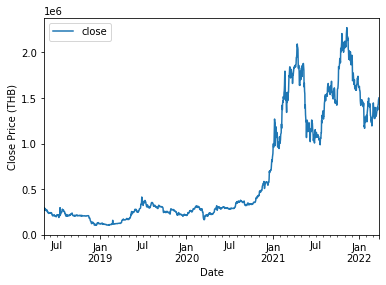

In [8]:
ax = df.plot(x='datetime', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (THB)")

In [9]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [11]:
SEQ_LEN = 15

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len):

    data = to_sequences(data_raw, seq_len)

    #num_train = int(train_split * data.shape[0])
    num_train =len(data) - 30
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN)

In [12]:
regressor = Sequential()

regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 64, return_sequences = True))
#regressor.add(Dropout(0.1))

#regressor.add(LSTM(units = 128, return_sequences = True))
#regressor.add(Dropout(0.1))

#regressor.add(LSTM(units = 64, return_sequences = True))
#regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 64, return_sequences = False))
regressor.add(Dropout(0.2))

#regressor.add(Dense(units = 20))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mse')

checkpoint_filepath = "savemodel/LSTM_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=False,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

history = regressor.fit(X_train, y_train, epochs = 300, batch_size = 128,validation_split=0.2,  callbacks=[model_checkpoint_callback])

Epoch 1/300
9/9 [==============================] - 3s 64ms/step - loss: 0.0339 - val_loss: 0.0036
Epoch 2/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0092
Epoch 3/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0128
Epoch 4/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 5/300
9/9 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 6/300
9/9 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/300
9/9 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 8/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 9/300
9/9 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 10/300
9/9 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 11/300
9/9 [=====

In [13]:
best_model = max( [ f for f in os.listdir("./savemodel") if f.startswith('LSTM_best') and f.endswith(".hdf5")] )
print(f"The best : {best_model}")

best_model_path="./savemodel/"+best_model
#best_model_path="./savemodel/"+"RNN_bestmodel_epoch299.hdf5"
print(f"Path best model: {best_model_path}")

best_regressor = tf.keras.models.load_model(best_model_path, compile=True)

score = best_regressor.evaluate(X_test, y_test, verbose=0)
print(f"{best_regressor.metrics_names} = {score}")

The best : LSTM_bestmodel_epoch295.hdf5
Path best model: ./savemodel/LSTM_bestmodel_epoch295.hdf5
['loss'] = 0.0005582535522989929


In [14]:
best_regressor.evaluate(X_test, y_test)

1/1 [==============================] - 0s 14ms/step - loss: 5.5825e-04


0.0005582535522989929

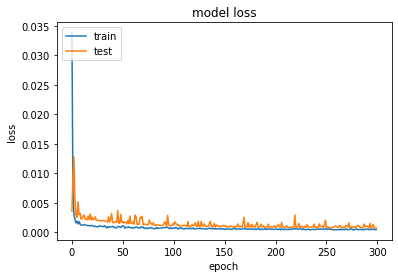

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

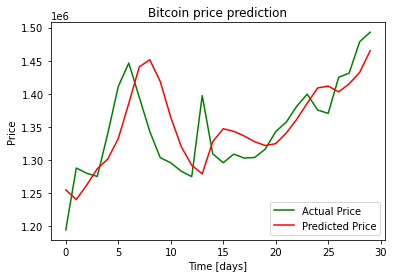

In [16]:
y_hat = best_regressor.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [17]:
sse = 0

for i in range(len(y_hat_inverse)):

    sse += ((y_test_inverse[i][0] - y_hat_inverse[i][0]) ** 2)

mse = sse / len(y_hat_inverse)

print(mse)

2621728661.542714
